In [2]:
import copy
import numpy as np
import pandas as pd

from src.common.functions import get_feature_importance
%cd /home/heza7322/PycharmProjects/missing-value-handling-in-carts
#%cd /Users/Henning/PycharmProjects/missing-value-handling-in-carts
import matplotlib.pyplot as plt
from src.binary_tree import BinaryTree
from src.trinary_tree import TrinaryTree
from src.weighted_tree import WeightedTree
from src.common.functions import get_indices, calculate_loss, fit_response

/home/heza7322/PycharmProjects/missing-value-handling-in-carts


In [6]:
idx = pd.IndexSlice

In [36]:
np.random.seed(11)

data_folder = 'example_notebooks/data_cleaned/'
file_names = {'balance_scale': 'balance_scale.csv',
              'german_credit': 'german_credit.csv',
              'iris': 'iris.csv',
              'lymphography':'lymphography.csv'}

tree_types = ['majority','mia','weighted','trinary']
missingnesses = ['all','test']
missing_probs = list(np.arange(0,10)/10)
index = pd.MultiIndex.from_product([file_names,missingnesses,tree_types],names = ['file_name','missingness','tree_type'])
errors = pd.DataFrame(index = index, columns = missing_probs)

max_depths = [1,2,3,4,5]
min_samples_leaf = 20

for file_name in file_names:
    # Load data
    df = pd.read_csv(data_folder+file_names[file_name],index_col = 0)
    features = [column for column in df.columns if column!='y']
    df.reset_index(inplace = True,drop=True)

    # Test train split
    n = len(df)
    df['test'] = False
    index_train = np.random.choice(df.index,int(n*0.2))
    df.loc[index_train,'test'] = True

    X_train = df.loc[~df['test'],features]
    y_train = df.loc[~df['test'],'y']
    X_test  = df.loc[df['test'],features]
    y_test  = df.loc[df['test'],'y']

    losses = pd.Series(index = np.arange(0,max(max_depths)), dtype = float)
    losses[0] = calculate_loss(y_test)

    for max_depth in max_depths:
        tree = BinaryTree(max_depth = max_depth, min_samples_leaf= min_samples_leaf)
        tree.fit(X_train, y_train)
        if y_test.dtype == float:
            y_hat = tree.predict(X_test)
            loss = calculate_loss(y_test,y_hat = y_hat)
        else:
            y_prob = tree.predict(X_test, prob = True)
            loss = calculate_loss(y_test,y_prob = y_prob)

        losses.loc[max_depth] = loss
        if max_depth>1:
            if losses.loc[max_depth]>=losses.loc[max_depth-1]:
                break

    max_depth = losses.idxmin()

    # Set up trees
    tree_types = {'majority': BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf, missing_rule='majority'),
                  'mia':      BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='mia'),
                  'trinary':  TrinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf),
                  'weighted': WeightedTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)}

    dfs = {0: df.copy()}
    n_to_remove = [0]
    for i in range(1,len(missing_probs)):
        n_to_remove += [int(missing_probs[i]*n) - sum(n_to_remove[:i])]
        dfs[i] = dfs[i-1].copy()
        for feature in features:
            to_remove = dfs[i].loc[~dfs[i][feature].isna()].sample(n_to_remove[i]).index
            dfs[i].loc[to_remove,feature] = np.nan

    # Fit trees
    trees = {}
    for i,missing_prob in enumerate(missing_probs):
        X_train = dfs[i].loc[~dfs[i]['test'],features]
        y_train = dfs[i].loc[~dfs[i]['test'],'y']
        X_test  = dfs[i].loc[dfs[i]['test'],features]
        y_test  = dfs[i].loc[dfs[i]['test'],'y']
        trees[i] = {}
        for tree_name in tree_types:
            trees[i][tree_name] = copy.deepcopy(tree_types[tree_name])
            trees[i][tree_name].fit(X_train,y_train)
            if y_test.dtype == float:
                y_hat = trees[i][tree_name].predict(X_test)
                loss = calculate_loss(y_test,y_hat = y_hat)
            else:
                y_prob = trees[i][tree_name].predict(X_test, prob = True)
                loss = calculate_loss(y_test,y_prob = y_prob)
            errors.loc[idx[file_name,'all',tree_name],missing_prob] = loss

    # Missingness of different frequencies ONLY in test data
    for i,missing_prob in enumerate(missing_probs):
        X_test  = dfs[i].loc[dfs[i]['test'],features]
        y_test  = dfs[i].loc[dfs[i]['test'],'y']
        for tree_name in tree_types:
            if y_test.dtype == float:
                y_hat = trees[0][tree_name].predict(X_test)
                loss = calculate_loss(y_test,y_hat = y_hat)
            else:
                y_prob = trees[0][tree_name].predict(X_test, prob = True)
                loss = calculate_loss(y_test,y_prob = y_prob)
            errors.loc[idx[file_name,'test',tree_name],missing_prob] = loss


In [37]:
errors_norm = pd.DataFrame(index = errors.index, columns = errors.columns)
for file_name in file_names:
    for missingness in missingnesses:
        errors_norm.loc[idx[file_name,missingness,:],:] = errors.loc[idx[file_name,missingness,:],:].div(errors.loc[idx[file_name,missingness,:],0],axis=0)

In [40]:
errors_norm_avg = errors_norm.groupby(['missingness','tree_type']).mean()

<Axes: >

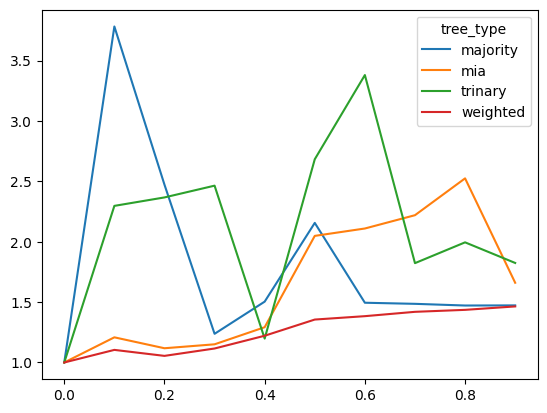

In [47]:
errors_norm_avg.loc[idx['all',:]].T.plot()

<Axes: >

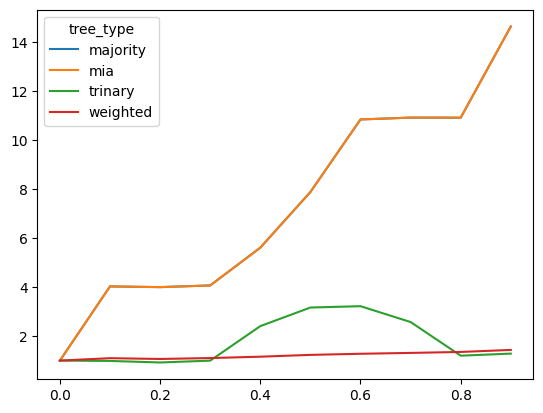

In [48]:
errors_norm_avg.loc[idx['test',:]].T.plot()